In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from pathlib import Path

H=100, W=100


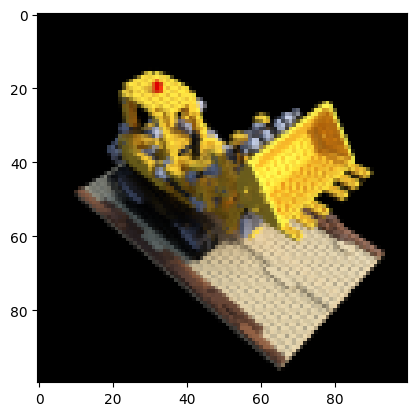

In [2]:
data = np.load("../data/tiny_nerf_data.npz")
imgs, poses, focal = data["images"], data["poses"], data["focal"]
_, H, W, _ = imgs.shape
test_img, test_pose = torch.tensor(imgs[101]), torch.tensor(poses[101])
imgs, poses = np.delete(imgs, 101, axis=0), np.delete(poses, 101, axis=0)

print(f"{H=}, {W=}")
plt.imshow(test_img)

In [7]:
img_paths[-1].stem

'1760'

In [10]:
data_path = Path("../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego")
img_paths  = sorted([f for f in data_path.glob("vis/*") if "_" not in f.stem], key=lambda x: int(x.stem))
pose_paths = sorted(data_path.glob("poses/*"))

poses = [np.load(f) for f in pose_paths]
img_paths

[PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/0.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/1.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/2.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/3.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/4.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/5.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/6.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/7.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/8.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/9.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/10.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/11.png'),
 PosixPath('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/12.png'),
 PosixPath('../../MobileR2L/model/t

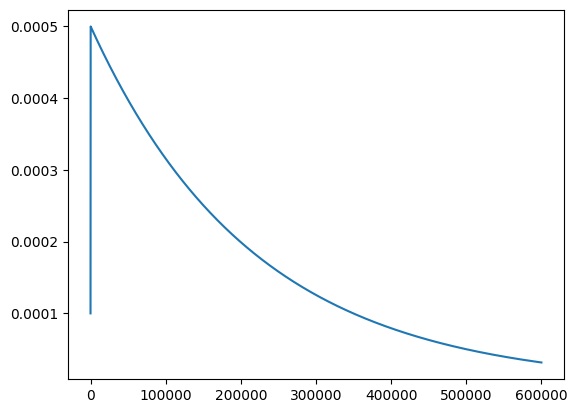

In [3]:
class args:
    lrate_decay = 500
    warmup_lr = "0.0001,200"
    lrate = 0.0005
    lr_scale = 1.0

def lr_schedule(global_step):
    decay_rate = 0.1
    decay_steps = args.lrate_decay * 1000
    if args.warmup_lr: # @mst: example '0.0001,2000'
        start_lr, end_iter = [float(x) for x in args.warmup_lr.split(',')]
        if global_step < end_iter: # increase lr until args.lrate
            new_lrate = (args.lrate - start_lr) / end_iter * global_step + start_lr
        else: # decrease lr as before
            new_lrate = args.lrate * (decay_rate ** ((global_step - end_iter) / decay_steps))
    else:
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
    new_lrate *= args.lr_scale
    return new_lrate

plt.plot([lr_schedule(iter) for iter in range(600_000)])

In [22]:
torch.tensor([[0., 1, 1]]).norm(dim=-1)

tensor([1.4142])

In [30]:
pose = torch.tensor(np.load('../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00001.npy'))

# look at something cam_pos --- idk what they are doing
def normalize(vec, axis):
    return vec / vec.norm(dim=axis)

def look_at(centers):
    forward_vec = normalize(centers, axis=-1)
    up_vec = torch.tensor([[0, 0, -1.]])
    right_vec = normalize(torch.cross(forward_vec, up_vec, -1), -1)
    up_vec = normalize(torch.cross(forward_vec, right_vec, -1), -1)

    poses = torch.eye(4, dtype=torch.float32)
    poses[:3, :3] = torch.stack([right_vec, up_vec, forward_vec], -1)
    poses[:3, -1] = centers
    return poses

def get_c2w(center):
    cam_pos = (center * (4.031128857175551 / 1.5)).unsqueeze(0)
    return look_at(cam_pos)

c2w = get_c2w(pose)
print(f"{c2w=}")

c2w=tensor([[-0.9376, -0.0589,  0.3428,  1.3817],
        [ 0.3478, -0.1587,  0.9240,  3.7249],
        [ 0.0000,  0.9856,  0.1693,  0.6824],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [39]:
# their implmementation

from einops import rearrange
from kornia import create_meshgrid

def lookAt(
        centers,
        camera_convention
    ):
    """Create c2w matrix from a camera center
       refer to: https://github.com/google-research/multinerf/blob/5d4c82831a9b94a87efada2eee6a993d530c4226/internal/camera_utils.py#L191
    """
    if camera_convention == 'openCV':
        forward_vector = -normalize(centers)
        up_vector = torch.FloatTensor([0, 0, -1]).unsqueeze(0)
        right_vector = normalize(torch.cross(up_vector, forward_vector, dim=-1))
        up_vector = normalize(torch.cross(forward_vector, right_vector, dim=-1))
    elif camera_convention == 'openGL':
        forward_vector = normalize(centers)
        up_vector = torch.FloatTensor([0, 0, -1]).unsqueeze(0)
        right_vector = normalize(torch.cross(forward_vector, up_vector, dim=-1))
        up_vector = normalize(torch.cross(forward_vector, right_vector, dim=-1))

    poses = torch.zeros((3, 4))
    poses[:3, :3] = torch.stack((right_vector, up_vector, forward_vector), dim=-1)
    poses[:3, 3] = centers
    return poses
    
def normalize(
        vectors
    ):
    if isinstance(vectors, torch.Tensor):
        return vectors / (torch.norm(vectors, dim=-1, keepdim=True) + 1e-10)
    # numpy array
    return vectors / (np.linalg.norm(vectors, axis=-1, keepdims=True) + 1e-10)

cam_pos = (
    (torch.FloatTensor(pose) * (4.031128857175551 / 1.5))
    .view(1, 3)
)
c2w = lookAt(cam_pos, "openGL")
print(f"{c2w=}")

def get_rays(
    directions,
    c2w
):
    """
        refer to ngp_pl implementation
    """
    if c2w.ndim==2:
        # Rotate ray directions from camera coordinate to the world coordinate
        rays_d = directions @ c2w[:, :3].T
    else:
        rays_d = (
            rearrange(directions, 'n c -> n 1 c') 
                @ rearrange(c2w[..., :3], 'n a b -> n b a')
        )
        rays_d = rearrange(rays_d, 'n 1 c -> n c')
    # The origin of all rays is the camera origin in world coordinate
    rays_o = c2w[..., 3].expand_as(rays_d).clone()
    return rays_o, rays_d

def get_ray_directions(
    H : int,
    W : int,
    focal : float,
    device : torch.device = torch.device('cpu'),
    camera_convention : str = 'openGL'
):
    # (H, W, 2)
    grid = create_meshgrid(H, W, False, device=device)[0]
    u, v = grid.unbind(-1)
    
    if camera_convention == 'openGL':
        directions = torch.stack(
            [
                (u - 0.5 * W + 0.5) / focal, 
                -(v - 0.5 * H + 0.5) / focal, 
                -torch.ones_like(u)
            ], -1
        )
    elif camera_convention == 'openCV':
        directions = torch.stack(
            [
                (u - 0.5 * W + 0.5) / focal, 
                (v - 0.5 * H + 0.5) / focal, 
                torch.ones_like(u)
            ], -1
        )
    return directions.reshape(-1, 3)

directions = get_ray_directions(100, 100, 138)
print(f"{directions=}")

rays_o, rays_d = get_rays(directions, c2w)
print(f"{rays_o=}")
print(f"{rays_d=}")

print(rays_d.shape)

c2w=tensor([[ 0.8591, -0.2423,  0.4508,  1.8173],
        [ 0.5118,  0.4068, -0.7567, -3.0503],
        [ 0.0000,  0.8808,  0.4735,  1.9086]])
directions=tensor([[-0.3587,  0.3587, -1.0000],
        [-0.3514,  0.3587, -1.0000],
        [-0.3442,  0.3587, -1.0000],
        ...,
        [ 0.3442, -0.3587, -1.0000],
        [ 0.3514, -0.3587, -1.0000],
        [ 0.3587, -0.3587, -1.0000]])
rays_o=tensor([[ 1.8173, -3.0503,  1.9086],
        [ 1.8173, -3.0503,  1.9086],
        [ 1.8173, -3.0503,  1.9086],
        ...,
        [ 1.8173, -3.0503,  1.9086],
        [ 1.8173, -3.0503,  1.9086],
        [ 1.8173, -3.0503,  1.9086]])
rays_d=tensor([[-0.8459,  0.7190, -0.1575],
        [-0.8397,  0.7227, -0.1575],
        [-0.8334,  0.7264, -0.1575],
        ...,
        [-0.0682,  0.7870, -0.7894],
        [-0.0620,  0.7907, -0.7894],
        [-0.0557,  0.7944, -0.7894]])
torch.Size([10000, 3])


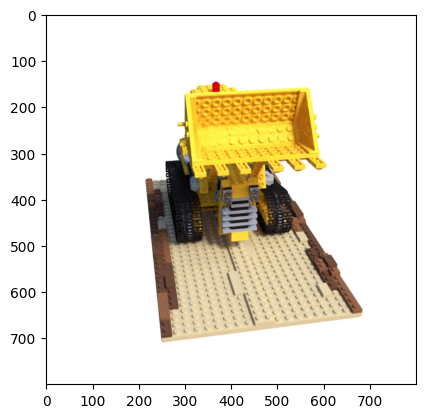

In [36]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import json


def encode_pos(x, emb_dim):
    rets = [x]
    for i in range(emb_dim):
        rets.append(torch.sin(2.**i * x))
        rets.append(torch.cos(2.**i * x))
    return torch.cat(rets, dim=0)

def get_ray_origin_dir(H, W, focal, pose):
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="xy")
    dirs = torch.stack([
        +(i - H/2) / focal,
        -(j - W/2) / focal,
        -torch.ones_like(i)
    ], dim=-1)
    ray_dirs = (dirs @ pose[:3, :3].T).permute(2, 0, 1)
    ray_origin = pose[:3, -1].view(3, 1, 1)
    return ray_origin, ray_dirs

def get_rays(H, W, focal, pose, near, far, num_samples, rand):
    rayo, rayd = get_ray_origin_dir(H, W, focal, pose)
    depths = torch.linspace(near, far, num_samples).view(num_samples, 1, 1, 1)
    if rand:
        noise = torch.rand([num_samples, 1, H, W])
        depths = depths + noise
    rays = rayo + rayd * depths
    rays = rays.reshape(-1, H, W)
    return rays


class PseudoDataset(Dataset):

    def __init__(self, root, num_samples, rand) -> None:
        super().__init__()
        self.num_samples = num_samples
        self.rand = rand

        root = Path(root)
        self.dataset_info = self._load_info(root/"hwf"/"dataset_info.json")
        self.img_paths = sorted([f for f in root.glob("vis/*") if "_" not in f.stem], key=lambda x: int(x.stem))
        self.poses = [get_c2w(self._load(f)) for f in sorted(root.glob("poses/*"))]

        assert len(self.img_paths) == len(self.poses),\
            f"Number of images does not match number of poses in the dataset at {root}."

    def __getitem__(self, index):
        img = read_image(self.img_paths[index]) / 255
        pose = self.poses[index]
        rays = get_rays(
            self.dataset_info["downscaled_height"],
            self.dataset_info["downscaled_width"],
            self.dataset_info["downscaled_focal"],
            pose,
            0, 5,
            self.num_samples,
            self.rand
        )
        return rays, img
    
    def __len__(self):
        return len(self.img_paths)

    @staticmethod
    def _load(fpath):
        return torch.tensor(np.load(fpath))
    
    @staticmethod
    def _load_info(fpath):
        with open(fpath, "r") as f:
            info = json.load(f)
        return info


dataset = PseudoDataset(data_path, 16, True)

rays, image = dataset[0]

rays.shape, image.shape

plt.imshow(image.permute(1, 2, 0))

In [135]:
def encode_pos(x, emb_dim):
    rets = [x]
    for i in range(emb_dim):
        rets.append(torch.sin(2.**i * x))
        rets.append(torch.cos(2.**i * x))
    return torch.cat(rets, dim=0)

def get_ray_origin_dir(H, W, focal, pose):
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="xy")
    dirs = torch.stack([
        +(i - H/2) / focal,
        -(j - W/2) / focal,
        -torch.ones_like(i)
    ], dim=-1)
    ray_dirs = (dirs @ pose[:3, :3].T).permute(2, 0, 1)
    ray_origin = pose[:3, -1].view(3, 1, 1)
    return ray_origin, ray_dirs

def get_rays(H, W, focal, pose, near, far, num_samples, emb_dim, rand):
    rayo, rayd = get_ray_origin_dir(H, W, focal, pose)
    depths = torch.linspace(near, far, num_samples).view(num_samples, 1, 1, 1)
    if rand:
        noise = torch.rand([num_samples, 1, H, W])
        depths = depths + noise
    rays = rayo + rayd * depths
    rays = rays.reshape(-1, H, W)
    return encode_pos(rays, emb_dim)

get_rays(H, W, focal, torch.tensor(poses[0]), 2, 6, 1, 0, "g").shape

torch.Size([3, 100, 100])

In [136]:
h, w, f = 4, 4, 2
near, far = 2, 6
num_samples = 2
emb_dim = 0
rand = True
pose = torch.tensor([
    [-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
    [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
    [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
    [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]
])

rayo, rayd = get_ray_origin_dir(h, w, f, pose)
print(rayd.shape)
depths = torch.linspace(near, far, num_samples).view(num_samples, 1, 1, 1)
if rand:
    noise = torch.rand([num_samples, 1, h, w])
    depths = depths + noise
print(depths.shape)
rays = rayo + (rayd * depths.view(-1, 1, 1, 1))
rays = rays.reshape(-1, h, w)
rays = encode_pos(rays, emb_dim)
print(rays)

torch.Size([3, 4, 4])
torch.Size([2, 1, 4, 4])
tensor([[[ 1.9956,  0.9886, -0.0185, -1.0255],
         [ 1.9914,  0.9843, -0.0227, -1.0297],
         [ 1.9871,  0.9801, -0.0269, -1.0339],
         [ 1.9829,  0.9759, -0.0311, -1.0382]],

        [[ 1.3486,  1.3345,  1.3204,  1.3063],
         [ 1.6504,  1.6363,  1.6222,  1.6081],
         [ 1.9522,  1.9381,  1.9240,  1.9099],
         [ 2.2540,  2.2399,  2.2258,  2.2117]],

        [[ 2.5261,  2.5261,  2.5261,  2.5261],
         [ 1.5653,  1.5653,  1.5653,  1.5653],
         [ 0.6044,  0.6044,  0.6044,  0.6044],
         [-0.3564, -0.3564, -0.3564, -0.3564]],

        ...,

        [[ 6.2503,  3.1526,  0.0549, -3.0429],
         [ 6.2373,  3.1396,  0.0419, -3.0558],
         [ 6.2243,  3.1266,  0.0289, -3.0688],
         [ 6.2113,  3.1136,  0.0159, -3.0818]],

        [[-3.8352, -3.8786, -3.9219, -3.9653],
         [-2.9069, -2.9502, -2.9936, -3.0369],
         [-1.9785, -2.0219, -2.0652, -2.1085],
         [-1.0502, -1.0935, -1.1369, -

In [137]:
class ResNetBlock(nn.Module):

    def __init__(self, channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        skip = x
        x = self.act(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return x + skip

class SuperResBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, num_convs):
        layers = [
            #nn.Upsample(scale_factor=2),
            #nn.Conv2d(in_channels, out_channels, 1)
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        ]
        for _ in range(num_convs):
            layers.append(ResNetBlock(out_channels, 1))
        super().__init__(*layers)

class MobileR2L(nn.Sequential):

    def __init__(self, in_channels, hidden_channels, num_layers, num_sr_modules):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 1), nn.ReLU()
        )
        self.body = nn.Sequential(*[
            ResNetBlock(hidden_channels, 1)
            for _ in range(num_layers)
        ])
        self.upscale = nn.Sequential(*[
            SuperResBlock(hidden_channels//(2**i), hidden_channels//(2**(i+1)), 2)
            for i in range(num_sr_modules)
        ])
        self.tail = nn.Conv2d(hidden_channels//(2**num_sr_modules), 3, 1)
    
    def forward(self, x):
        x = self.head(x)
        x = self.body(x) + x
        x = self.upscale(x)
        return self.tail(x)

with torch.no_grad():
    model = MobileR2L(21, 256, 8, 0).cuda()
    x = get_rays(H, W, focal, torch.tensor(poses[0]), 2, 6, 1, 3, rand=True).unsqueeze(0).cuda()
    #%timeit model(x)
    out = model(x)
    print(out.shape)
    print(sum(p.numel() for p in model.parameters()))
    #torch.save(model, "test_tr.pt")

torch.Size([1, 3, 100, 100])
1067267


100%|████████████████████| 40000/40000 [1:23:23<00:00,  7.99it/s, loss=2.54e-03]


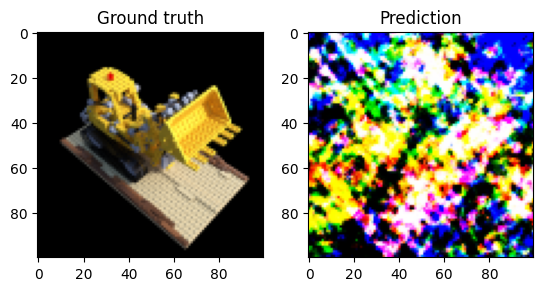

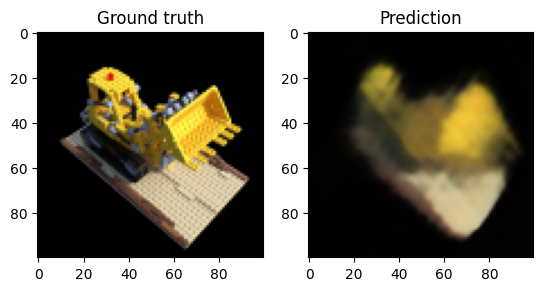

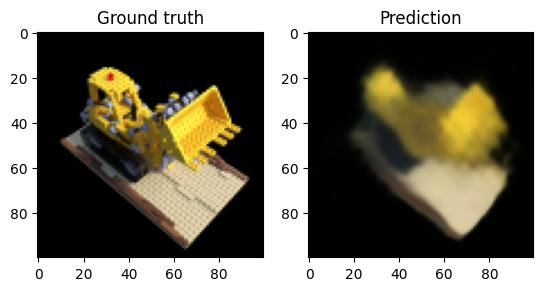

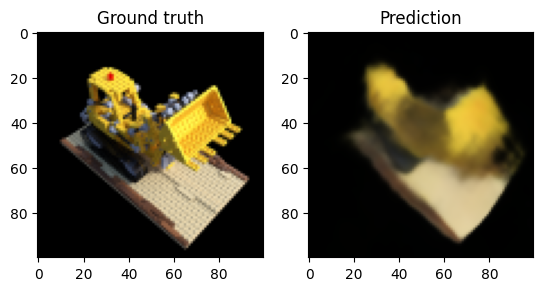

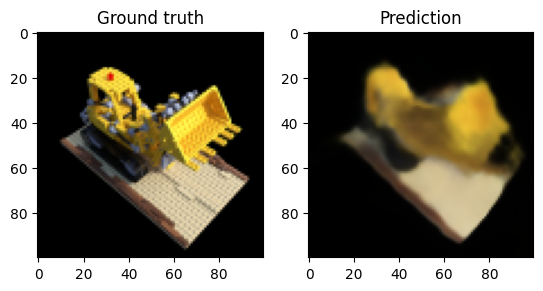

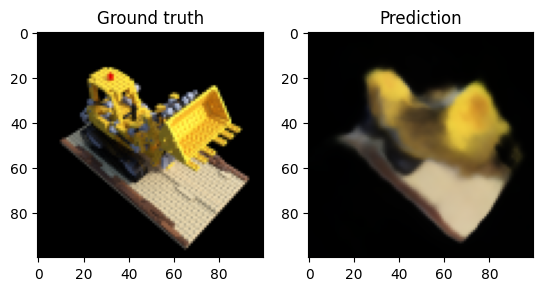

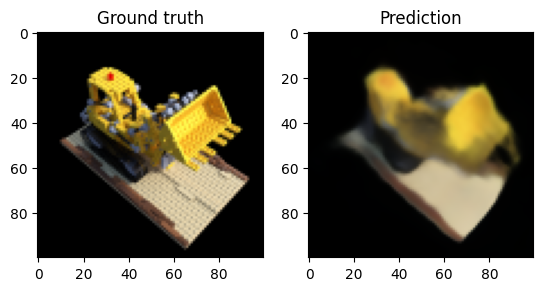

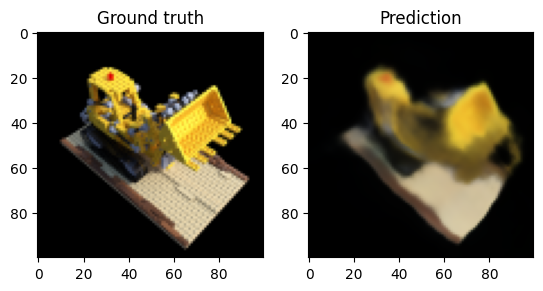

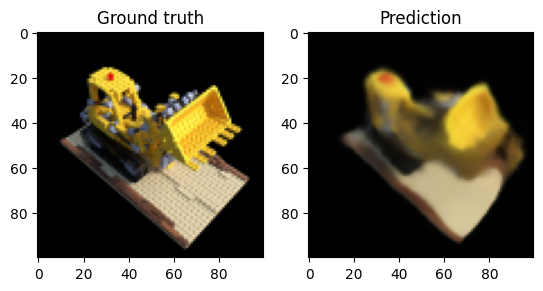

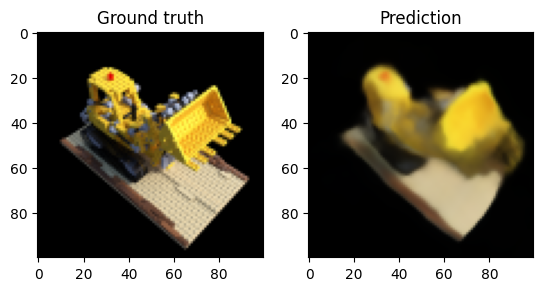

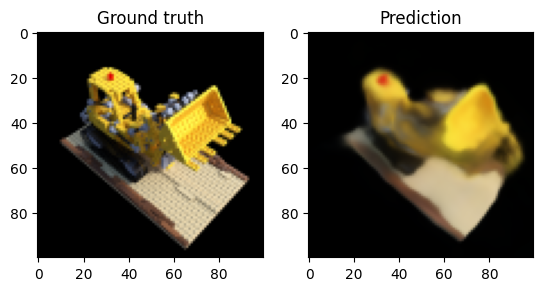

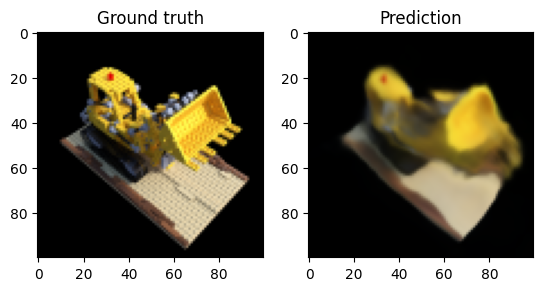

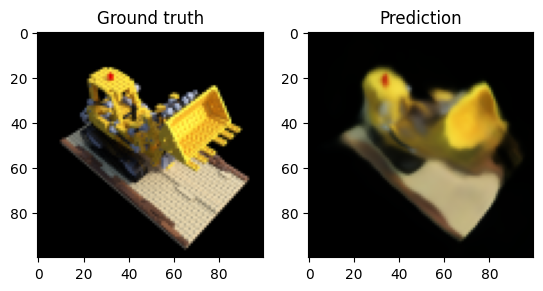

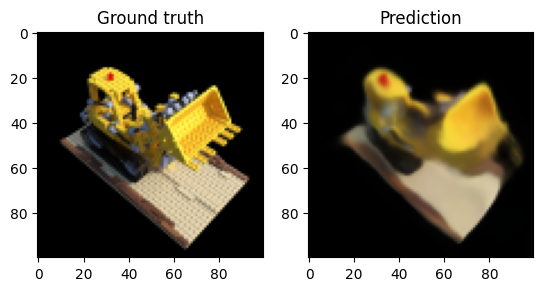

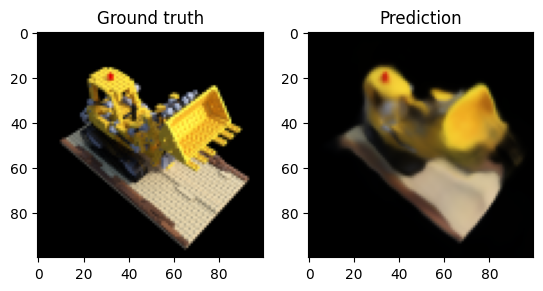

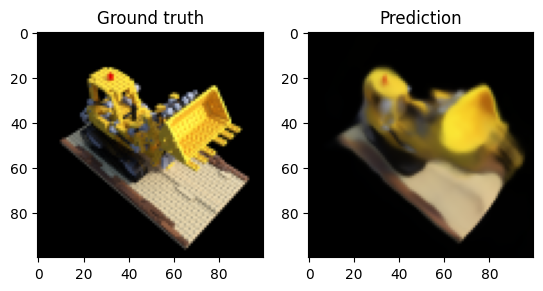

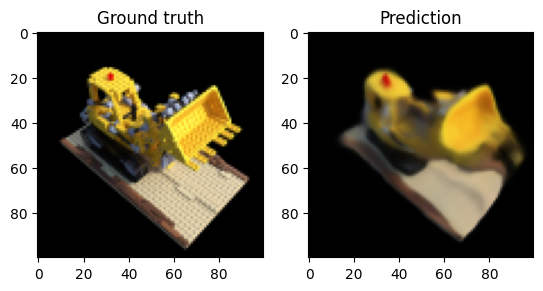

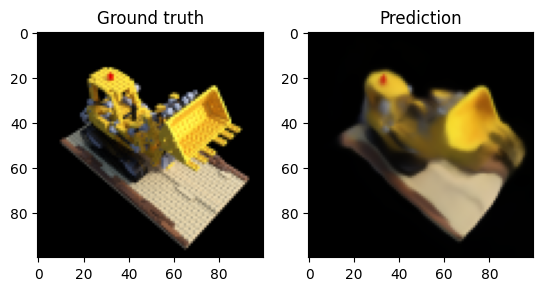

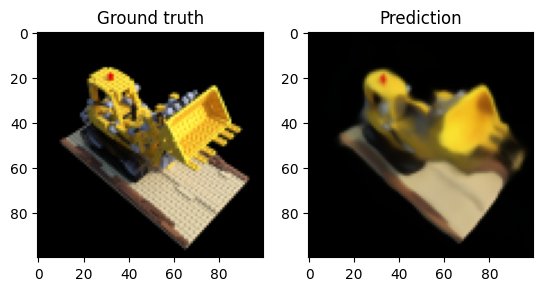

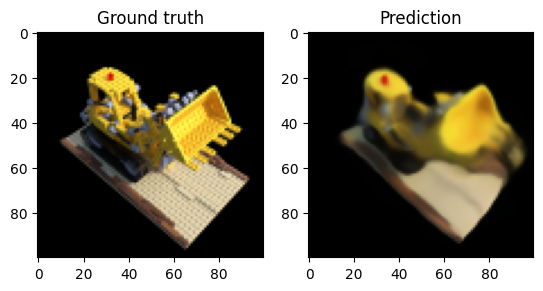

In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"
images_to_plot = 20

emb_dim = 6
num_samples = 16
num_iters = 40000
near, far = 2., 6.
rand = True
num_images, H, W, _ = imgs.shape

model = MobileR2L(3*(emb_dim*2+1)*num_samples, 256, 32, 0).to(device)
optim = torch.optim.Adam(model.parameters(), 1e-3)
criterion = F.mse_loss

history = []
for i in (pbar := tqdm(range(num_iters), ncols=80)):
    
    index = torch.randint(0, num_images, [1])[0]
    img = torch.tensor(imgs[index]).permute(2, 0, 1).to(device)
    pose = torch.tensor(poses[index])
    
    x = get_rays(
        H, W, focal, pose, near, far,
        num_samples, emb_dim, rand).unsqueeze(0).to(device)
    pred_img = F.sigmoid(model(x)).squeeze(0)
    loss = criterion(pred_img, img)

    history.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_postfix({"loss": f"{loss.item():.2e}"})

    if i % (num_iters // images_to_plot) == 0:
        with torch.no_grad():
            x = get_rays(
                H, W, focal, test_pose, near, far,
                num_samples, emb_dim, rand=False).unsqueeze(0).to(device)
            pred_img = F.sigmoid(model(x)).squeeze(0).permute(1, 2, 0)

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(test_img)
        ax[0].set_title("Ground truth")
        ax[1].imshow(pred_img.cpu())
        ax[1].set_title("Prediction")

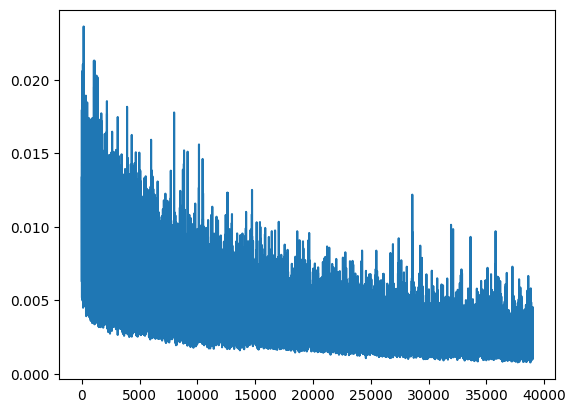

In [141]:
plt.plot(history[1000:])

In [142]:
torch.save(model, "tiny_nelf.pt")

Text(0.5, 1.0, 'Prediction')

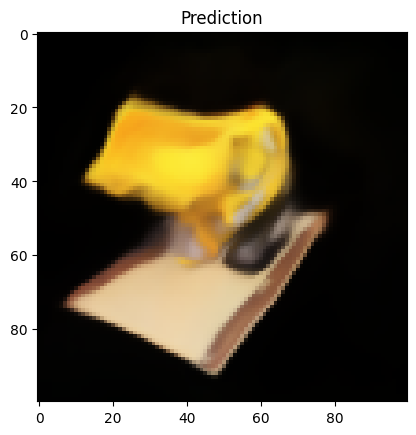

In [139]:
from math import sin, cos, radians

tr_r = lambda r : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,r],
    [0,0,0,1.],
])

rot_phi = lambda phi: torch.tensor([
    [1,0,0,0],
    [0,cos(phi),-sin(phi),0],
    [0,sin(phi), cos(phi),0],
    [0,0,0,1.],
])

rot_theta = lambda th : torch.tensor([
    [cos(th),0,-sin(th),0],
    [0,1,0,0],
    [sin(th),0, cos(th),0],
    [0,0,0,1.],
])

def get_pose_spherical(r, phi, theta):
    perm = torch.tensor([[-1.,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    return perm @ rot_theta(radians(theta)) @ rot_phi(radians(phi)) @ tr_r(r)

pose = get_pose_spherical(4, -30, 150)

with torch.no_grad():
    x = get_rays(H, W, focal, pose, near, far, num_samples, emb_dim, rand=False).unsqueeze(0).to(device)
    pred_img = F.sigmoid(model(x)).squeeze(0).permute(1, 2, 0)
fig, ax = plt.subplots(1, 1)
ax.imshow(pred_img.cpu())
ax.set_title("Prediction")

In [140]:
import cv2
writer = cv2.VideoWriter(
    "output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (100,100))

for th in tqdm(torch.linspace(0, 360, 1200)):
    pose = get_pose_spherical(4,-30, th)
    rays = get_rays(H, W, focal, pose, near, far, num_samples, emb_dim, False).to(device)
    with torch.no_grad():
        pred_img = F.sigmoid(model(rays.unsqueeze(0))).squeeze(0).permute(1, 2, 0)
    cv2img = cv2.cvtColor((pred_img * 255).cpu().to(torch.uint8).numpy(), cv2.COLOR_RGB2BGR)
    writer.write(cv2img)

writer.release()

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:00<00:00, 19.98it/s]


In [80]:
rays = torch.zeros(624, 50, 50, dtype=torch.float32)

In [99]:
import onnxruntime
out_path = "inference_csr/model.onnx"

#include your pytorch model creation or loading here
model = model.eval()
dummy_input = rays.unsqueeze(0)

#save to onnx
torch.onnx.export(model,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  out_path,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=17,          # the ONNX version to export the model to
                  do_constant_folding=False, # whether to execute constant folding for optimization
                  output_names=["out"], 
                  )

torch_out=model(dummy_input)
ort_session = onnxruntime.InferenceSession(out_path)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [100]:
ort_outs[0].shape

(1, 3, 50, 50)

In [101]:
ort_outs[0]

array([[[[-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         ...,
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784]],

        [[ 1.2432957 ,  1.2432957 ,  1.2432957 , ...,  1.2432957 ,
           1.2432957 ,  1.2432957 ],
         [ 1.2432957 ,  1.2432957 ,  1.2432957 , ...,  1.2432957 ,
           1.2432957 ,  1.2432957 ],
         [ 1.2432957 ,  1.2432957 ,  1.2432957 , ...,  1.2432957 ,
           1.2432957 ,  1.2432957 ],
         ...,
         [ 1.2432957 ,  1.2432957 

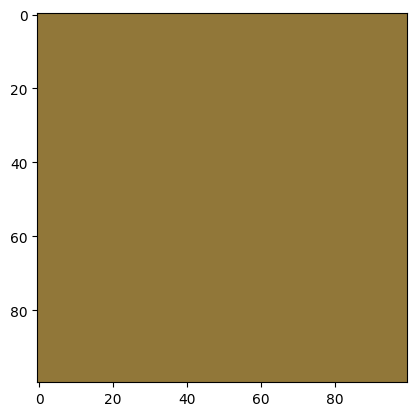

In [41]:
import onnxruntime
ort_session = onnxruntime.InferenceSession(out_path)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)
plt.imshow(F.sigmoid(torch.tensor(ort_outs[0])).squeeze(0).permute(1, 2, 0))

In [42]:
ort_outs

[array([[[[ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          ...,
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ]],
 
         [[-0.12756142, -0.12756142, -0.12756142, ..., -0.12756142,
           -0.12756142, -0.12756142],
          [-0.12756142, -0.12756142, -0.12756142, ..., -0.12756142,
           -0.12756142, -0.12756142],
          [-0.12756142, -0.12756142, -0.12756142, ..., -0.12756142,
           -0.12756142, -0.12756142],
          ...,
          [-0

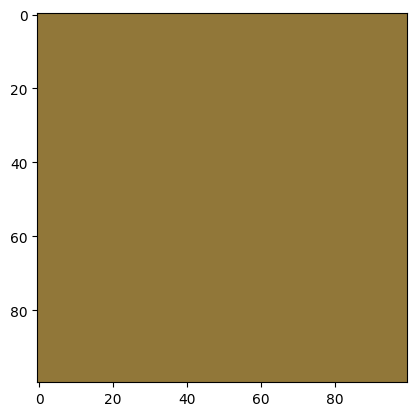

In [22]:
with torch.no_grad():
    torch_out = model(rays.unsqueeze(0))

plt.imshow(F.sigmoid(torch_out).squeeze(0).permute(1, 2, 0))